In [1]:
import pykat
from pykat.ifo import aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt
import numpy as np

pykat.init_pykat_plotting()

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



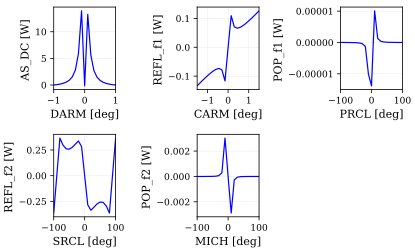

In [3]:
base = aligo.make_kat("design_with_IMC_HAM2_FI_OMC")
base = aligo.setup(base)
base.L0.P = 30.0

#mods
base.SRM.T = .37
base.parse("qshotS NSR_without_RP 1 $fs nAS")
base.parse("qnoisedS NSR_with_RP 1 $fs nAS")

#plot
aligo.plot.error_signals(base, xlimits=(-1, 1), steps=20)

In [4]:
base.IFO.zero_locks()

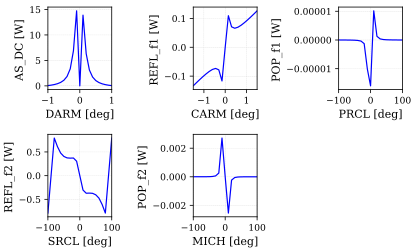

In [5]:
kat = base.deepcopy()
kat.SRM.T = .323
for i in range(2):
    kat.IFO.zero_locks()
    
aligo.plot.error_signals(kat, xlimits=(-1, 1), steps=20)

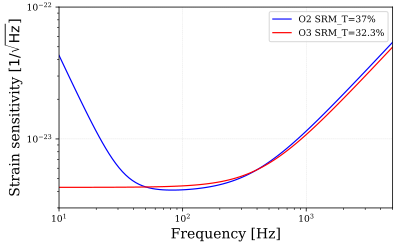

In [6]:
base.IFO.suspend_mirrors_z()

base.parse(base.IFO.DARM.transfer())
base.parse("qnoised noise 1 $fs nAS")
out1 = base.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

kat.parse(kat.IFO.DARM.transfer())
kat.parse("qnoised noise 1 $fs nAS")
out2 = kat.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

ax = plt.subplot(111)
plt.loglog(out1.x, out1['NSR_with_RP'],label="O2 SRM_T=37%")
plt.loglog(out2.x, out2['NSR_with_RP'], label="O3 SRM_T=32.3%")

ax.legend()

plt.xlabel("Frequency [Hz]",fontsize=14)
plt.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=14)

plt.ylim(3e-24,1e-22)

plt.savefig('ChangeinSRM_strain.png')

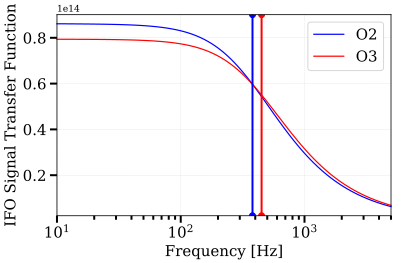

In [7]:
plt.semilogx(out1.x, out1[base.IFO.DARM.transfer_name()],label="O2")
plt.semilogx(out2.x, out2[kat.IFO.DARM.transfer_name()], label="O3")

plt.axvline(x=450,marker='o',linewidth=2, color='r')
plt.axvline(x=380,marker='o',linewidth=2, color='b')

plt.xlabel("Frequency [Hz]",fontsize=15)
plt.ylabel("IFO Signal Transfer Function",fontsize=15)

###Main plot formatting
plt.tick_params(labelsize=15)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4)
plt.grid(True, zorder=-1)
plt.legend(fontsize=15)

plt.savefig("ChangeinSRM_TF.png")

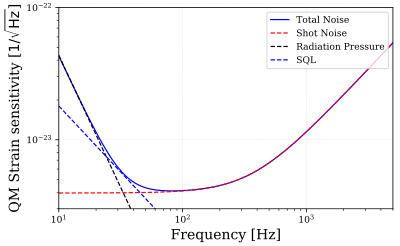

In [18]:
#radiation pressure estimate
def rad_pr(x):
    scale = 4.35e-21
    rad = scale/x**2
    return rad

#sql estimate
def sql(x):
    scale = 1.8e-22
    sql_out = scale/x
    return sql_out

f = np.linspace(10,5000,100)
rad_press = rad_pr(f)
stan_qm_limit = sql(f)

base.IFO.suspend_mirrors_z()
ax = plt.subplot(111)

#aligo.plot.strain_sensitivity(base, ax=ax)
ax.loglog(out1.x,out1['NSR_with_RP'],label='Total Noise',color='b')
ax.loglog(out1.x,out1['NSR_without_RP'],"--",label='Shot Noise',color='r')
ax.loglog(f,rad_press,"--",label="Radiation Pressure",color='k')
ax.loglog(f,stan_qm_limit,"--",label="SQL")
ax.legend(loc=1)

plt.xlabel("Frequency [Hz]",fontsize=14)
plt.ylabel("QM Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=14)

plt.ylim(3e-24,1e-22)
plt.savefig("ShotNoise_RP_TotalQM.png")

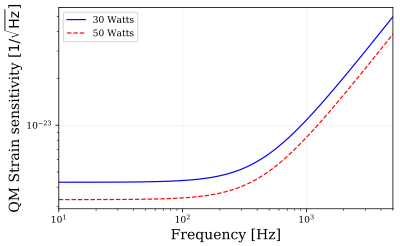

In [9]:
#increasing laser power from 30 Watts to 50 Watts.
kat2= kat.deepcopy()
kat2.parse(base.IFO.DARM.transfer())
kat2.parse("qnoised noise 1 $fs nAS")
kat2.L0.P=30
out2 = kat2.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

kat3= kat.deepcopy()
kat3.parse(base.IFO.DARM.transfer())
kat3.parse("qnoised noise 1 $fs nAS")
kat3.L0.P=50
out3 = kat3.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=100)

ax = plt.subplot(111)
ax.loglog(out1.x,out2['NSR_with_RP'],label='30 Watts',color='b')
ax.loglog(out1.x,out3['NSR_with_RP'],"--",label='50 Watts',color='r')
ax.legend()

plt.xlabel("Frequency [Hz]",fontsize=14)
plt.ylabel("QM Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=14)
plt.savefig("30W_50W_Strain.png")
